# Purpose
Goal is to use a few input points to generate all the Zaber coordinates (and then mm coordinates) for the tile centers and produce a csv for use in Bonsai. Also, it would be nice to get all the tile pole locations for making simulations (making hexes, etc.)

# imports

In [1]:
import os, sys, math
from datetime import datetime
import tifffile as tif
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

# functions

In [2]:
def get_row_vals(centers,index_of_centers,length_of_row):
    ''' function to auto-generate row values from a single center val
    INPUTS:
        1. centers: a tuple or list of center values for a tile in Zaber units (e.g. ls = 238800, ax=47200 the input would be [238800,47200] or (238800,47200))
        2. index_of_centers: an integer indicating which tile value you're inputting (e.g. M1 = element 0, M2 = element 1... etc)
        3. length_of_row: an integer indicating how many tiles in the row (e.g. 1 if A, 4 if B... 13 if M... 1 if Q)
    OUTPUTS:
        two lists ls_row_vals and ax_row_vals
    EXAMPLE:
        M1c = (230100, 46500)
        M_ls_cs,M_ax_cs = get_row_vals(M1c,0,13)
        print(M_ls_cs)
        print(M_ax_cs)
        > [230100, 228100, 226100, 224100, 222100, 220100, 218100, 216100, 214100, 212100, 210100, 208100, 206100]
        > [46500, 67700, 88900, 110100, 131300, 152500, 173700, 194900, 216100, 237300, 258500, 279700, 300900]
        
    NOTE: if you have K2c, try
        K_ls_cs, K_ax_cs = get_row_vals(K2c,1,13) because K2 is the 1st element in the list of K tile values from 1-13
    '''
    ls_row_offset = -1900
    ax_row_offset= 21400
    print('using ls_row_offset of {} and ax_row_offset of {}'.format(ls_row_offset,ax_row_offset))
    ls = centers[0]
    ax = centers[1]
    ls_row_vals=[]
    ax_row_vals=[]
    for i in np.arange(0-index_of_centers,length_of_row-index_of_centers):
        ls_row_vals.append(ls+i*ls_row_offset)
        ax_row_vals.append(ax+i*ax_row_offset)
    return ls_row_vals, ax_row_vals

In [3]:
def get_neighbor_tile(centers,direction):
    ''' INPUTS
        1. centers: a tuple or list of center values for a tile in Zaber units (e.g. ls = 238800, ax=47200 the input would be [238800,47200] or (238800,47200))
        2. direction: an int, either 0 for above right or 1 for below right (e.g. to get M2 from L2, use 1. to get L1 from M1, use 0)
        
        TODO later I should make this more flexible and harder to mess up
        OUTPUTS:
        1. new list with the center values in [ls,ax]
    '''
    ls = centers[0]
    ax = centers[1]
    M1_to_L1_offset = [-19500,9200]
    L1_to_M2_offset = [17600,12200]
    if direction == 0:
        new_centers = [ls+M1_to_L1_offset[0],ax+M1_to_L1_offset[1]]
        print('generated the tile center above and right of the values provided (e.g. M1 center entered, want L1 centers) using {} offset'.format(M1_to_L1_offset))
    elif direction == 1:
        new_centers = [ls+L1_to_M2_offset[0],ax+L1_to_M2_offset[1]]
        print('generated the tile center from below and right of the values provided (e.g. L1 center entered, want M2 centers) using {} offset'.format(L1_to_M2_offset))
    else:
        print('ERROR: you entered {}, which must be either 0 (for above, right) or 1 (for below, right)')
        new_centers=[]
    return new_centers

In [4]:
def get_relative_vals(df, location1, location2):
    '''
    INPUTS: 
        1. df: a pandas DataFrame with three columns: name, ls_guess, and ax_new_guess
        2. 
        3. 
    OUTPUTS:
        1. ls_high the highest ls value as an integer
        2. ls_low the lowest ls value as an integer
        3. ax_high the highest ax value as an integer
        4. ax_low the lowest ax value as an integer
    '''
    ax1= int(df.ax_new_guess[df.name==location1]/100)
    ax2 = int(df.ax_new_guess[df.name==location2]/100)
    ls1= int(df.ls_guess[df.name==location1]/100)
    ls2 = int(df.ls_guess[df.name==location2]/100)
    if ls1 > ls2:
        ls_high = ls1
        ls_low = ls2
    else:
        ls_low = ls1
        ls_high = ls2
    if ax1 > ax2:
        ax_low = ax2
        ax_high = ax1
    else:
        ax_low = ax1
        ax_high = ax2
    return ls_high,ls_low,ax_high,ax_low

In [5]:
def get_closest(list_input,num):
    aux = []
    for val in list_input:
        aux.append(abs(num-val))

    return aux.index(min(aux))

In [6]:
def getpoints(p1, p2):
    # Sort both points first.
    (x1, y1), (x2, y2) = sorted([p1, p2])
    a = b = 0.0
    yvals=[]
    xvals=np.arange(int(x1), int(x2) + 1)    
    # First point is in (0, y).
    if x1 == 0.0:
        b = y1
        a = (y2 - y1) / x2
    elif x2 == 0.0:
        # Second point is in (0, y).
        b = y2
        a = (y1 - y2) / x1
    else:
        # Both points are valid.
        b = (y2 - (y1 * x2) / x1) / (1 - (x2 / x1))
        a = (y1 - b) / x1
        for x in xvals:
            yvals.append(a * float(x) + b)
    yvals=[round(val) for val in yvals]
    axs=[]
    lss=[]
    for val in np.arange(np.min(yvals),np.max(yvals)):
        i=get_closest(yvals,val) # gets integer of yval closest
        lss.append(xvals[i])
        axs.append(yvals[i])
    return (lss, axs)

In [67]:
def rot_list_of_ax_ls(ax_list,ls_list,angle):
    # first check lists are same length
    if len(ax_list)!=len(ls_list):
        print('ERROR, your lists are two different lengths! 1st argument, ax_list is {} and 2nd argument ls_list is {}'.format(len(ax_list),len(ls_list)))
    else:
        ax_new=[]
        ls_new=[]
        
        ax_com=np.mean(ax_list)
        ls_com = np.mean(ls_list)
        ax_corr = ax_list-ax_com
        ls_corr = ls_list-ls_com
        print('using angle of {} degrees'.format(angle))
        alfa = angle*math.pi/180
        for i in range(len(ax_list)):
            ax_new.append((math.cos(alfa)*ax_corr[i]-math.sin(alfa)*ls_corr[i])+ax_com)
            ls_new.append((math.sin(alfa)*ax_corr[i]+math.cos(alfa)*ls_corr[i])+ls_com)
    return [ax_new,ls_new]

In [8]:
# from M1 top
M1_top_ls= 238800
M1_top_ax= 47200

# middle val = top + offset
# middle - top = offset
middle_from_0_offset = [227900-219000,57300-56600]
middle_from_0_offset

# get M1 center
M1c = (M1_top_ls+middle_from_0_offset[0],M1_top_ax+middle_from_0_offset[1])

# get all M centers (13)

M_ls_cs,M_ax_cs = get_row_vals(M1c,0,13)
    
# get L centers (12)
L1c = get_neighbor_tile(M1c,0)
L_ls_cs,L_ax_cs = get_row_vals(L1c,0,12)

using ls_row_offset of -1900 and ax_row_offset of 21400
generated the tile center above and right of the values provided (e.g. M1 center entered, want L1 centers) using [-19500, 9200] offset
using ls_row_offset of -1900 and ax_row_offset of 21400


In [9]:
# get K centers, using K2
K2c=get_neighbor_tile(L1c,0)
print(K2c)
K_ls_cs,K_ax_cs = get_row_vals(K2c,1,13)

generated the tile center above and right of the values provided (e.g. M1 center entered, want L1 centers) using [-19500, 9200] offset
[208700, 66300]
using ls_row_offset of -1900 and ax_row_offset of 21400


In [10]:
# get Js, Hs, Fs
# J from L
J1c = get_neighbor_tile([K_ls_cs[0],K_ax_cs[0]],0)
J_ls_cs,J_ax_cs = get_row_vals(J1c,0,12)

I2c = get_neighbor_tile(J1c,0)
I_ls_cs,I_ax_cs = get_row_vals(I2c,1,13)

H1c = get_neighbor_tile([I_ls_cs[0],I_ax_cs[0]],0)
H_ls_cs,H_ax_cs = get_row_vals(H1c,0,12)

G2c = get_neighbor_tile(H1c,0)
G_ls_cs,G_ax_cs = get_row_vals(G2c,1,13)

F2c = get_neighbor_tile(G2c,0)
F_ls_cs,F_ax_cs = get_row_vals(F2c,1,12)

E2c = get_neighbor_tile([F_ls_cs[0],F_ax_cs[0]],0)
E_ls_cs,E_ax_cs = get_row_vals(E2c,1,13)

# get D1 from E2, make 10 Ds
D1c=get_neighbor_tile(E2c,0)
D_ls_cs,D_ax_cs = get_row_vals(D1c,0,10)

# get C1 from D2, make 7 Cs
C1c = get_neighbor_tile([D_ls_cs[1],D_ax_cs[1]],0)
C_ls_cs,C_ax_cs = get_row_vals(C1c,0,7)

# get B1 from C2, make 4 Bs
B1c = get_neighbor_tile([C_ls_cs[1],C_ax_cs[1]],0)
B_ls_cs,B_ax_cs = get_row_vals(B1c,0,4)

# get A1 from B2
A1c = get_neighbor_tile([B_ls_cs[1],B_ax_cs[1]],0)
A_ls_cs = [A1c[0]]
A_ax_cs = [A1c[1]]


generated the tile center above and right of the values provided (e.g. M1 center entered, want L1 centers) using [-19500, 9200] offset
using ls_row_offset of -1900 and ax_row_offset of 21400
generated the tile center above and right of the values provided (e.g. M1 center entered, want L1 centers) using [-19500, 9200] offset
using ls_row_offset of -1900 and ax_row_offset of 21400
generated the tile center above and right of the values provided (e.g. M1 center entered, want L1 centers) using [-19500, 9200] offset
using ls_row_offset of -1900 and ax_row_offset of 21400
generated the tile center above and right of the values provided (e.g. M1 center entered, want L1 centers) using [-19500, 9200] offset
using ls_row_offset of -1900 and ax_row_offset of 21400
generated the tile center above and right of the values provided (e.g. M1 center entered, want L1 centers) using [-19500, 9200] offset
using ls_row_offset of -1900 and ax_row_offset of 21400
generated the tile center above and right of 

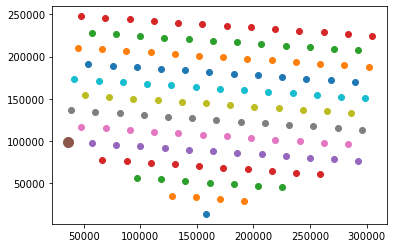

In [11]:
plt.scatter(A_ax_cs,A_ls_cs)
plt.scatter(B_ax_cs,B_ls_cs)
plt.scatter(C_ax_cs,C_ls_cs)
plt.scatter(D_ax_cs,D_ls_cs)
plt.scatter(E_ax_cs,E_ls_cs)
plt.scatter(E_ax_cs[0],E_ls_cs[0],s=100)
plt.scatter(F_ax_cs,F_ls_cs)
plt.scatter(G_ax_cs,G_ls_cs)
plt.scatter(H_ax_cs,H_ls_cs)
plt.scatter(I_ax_cs,I_ls_cs)
plt.scatter(J_ax_cs,J_ls_cs)
plt.scatter(K_ax_cs,K_ls_cs)
plt.scatter(L_ax_cs,L_ls_cs)
plt.scatter(M_ax_cs,M_ls_cs)


In [12]:
# get N1 from M2, get 10 Ns
N1c = get_neighbor_tile([M_ls_cs[1],M_ax_cs[1]],1)
N_ls_cs,N_ax_cs = get_row_vals(N1c,0,10)

# get O1 from N2, get 7 Os
O1c = get_neighbor_tile([N_ls_cs[1],N_ax_cs[1]],1)
O_ls_cs,O_ax_cs = get_row_vals(O1c,0,7)

# get P1 from O2, get 4 Ps
P1c = get_neighbor_tile([O_ls_cs[1],O_ax_cs[1]],1)
P_ls_cs,P_ax_cs = get_row_vals(P1c,0,4)

# g15 Q1 from Ps
Q1c = get_neighbor_tile([P_ls_cs[1],P_ax_cs[1]],1)
Q_ls_cs = [Q1c[0]]
Q_ax_cs = [Q1c[1]]


generated the tile center from below and right of the values provided (e.g. L1 center entered, want M2 centers) using [17600, 12200] offset
using ls_row_offset of -1900 and ax_row_offset of 21400
generated the tile center from below and right of the values provided (e.g. L1 center entered, want M2 centers) using [17600, 12200] offset
using ls_row_offset of -1900 and ax_row_offset of 21400
generated the tile center from below and right of the values provided (e.g. L1 center entered, want M2 centers) using [17600, 12200] offset
using ls_row_offset of -1900 and ax_row_offset of 21400
generated the tile center from below and right of the values provided (e.g. L1 center entered, want M2 centers) using [17600, 12200] offset


In [13]:
all_ax_cs = [A_ax_cs,B_ax_cs,C_ax_cs,D_ax_cs,E_ax_cs,F_ax_cs,G_ax_cs,H_ax_cs,I_ax_cs,J_ax_cs,K_ax_cs,L_ax_cs,M_ax_cs,N_ax_cs,O_ax_cs,P_ax_cs,Q_ax_cs]
all_ls_cs = [A_ls_cs,B_ls_cs,C_ls_cs,D_ls_cs,E_ls_cs,F_ls_cs,G_ls_cs,H_ls_cs,I_ls_cs,J_ls_cs,K_ls_cs,L_ls_cs,M_ls_cs,N_ls_cs,O_ls_cs,P_ls_cs,Q_ls_cs]

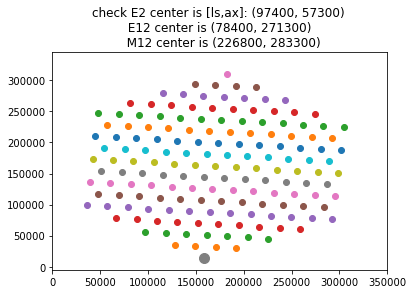

In [15]:
for i in np.arange(0,len(all_ax_cs)):
    plt.scatter(all_ax_cs[i],all_ls_cs[i])
plt.scatter(all_ax_cs[0],all_ls_cs[0],s=100)
    
plt.xlim([0,350000])
plt.ylim([-5000,345000])
plt.title('check E2 center is [ls,ax]: {} \n E12 center is {} \n  M12 center is {}'.format((E_ls_cs[1],E_ax_cs[1]),(E_ls_cs[11],E_ax_cs[11]),(M_ls_cs[11],M_ax_cs[11])))
#plt.scatter(current_file.ax_new_guess,current_file.ls_guess,c='k',alpha=0.2)
plt.show()

In [16]:
alpha = 'ABCDEFGHIJLKMNOPQ'
numera = np.arange(1,14).astype(str)
print(alpha,numera)

ABCDEFGHIJLKMNOPQ ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13']


In [17]:
names = []
ls_guesses = []
ax_new_guesses = []

for i in np.arange(0,len(all_ax_cs)):
    print(i)
    curr_ax = all_ax_cs[i]
    curr_ls = all_ls_cs[i]

    for j in np.arange(0,len(curr_ax)):
        names.append(alpha[i]+numera[j])
        ls_guesses.append(int(curr_ls[j]))
        ax_new_guesses.append(int(curr_ax[j]))
new_dict = {'name':names,'ls_guess':ls_guesses,'ax_new_guess':ax_new_guesses}
new_csv = pd.DataFrame(new_dict)        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [18]:
# create name and save out file
now = datetime.now()
filestring = "../../../zaber_centers_"+now.strftime("%Y%m%d")+".csv"
filestring
new_csv.to_csv(filestring)

# image files

In [344]:
# if not running all at once, load most recent zaber_centers file
new_csv = pd.read_csv('/Users/dennise/Desktop/zaber_centers_20240104.csv').drop(columns="Unnamed: 0")
new_csv

,name,ls_guess,ax_new_guess
0,A1,13700,158300
1,B1,35100,127700
2,B2,33200,149100
3,B3,31300,170500
4,B4,29400,191900
...,...,...,...
152,P1,294800,148700
153,P2,292900,170100
154,P3,291000,191500
155,P4,289100,212900


# trying to rotate points

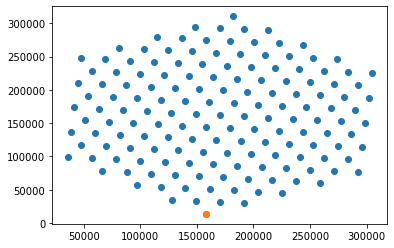

In [68]:
plt.scatter(new_csv.ax_new_guess,new_csv.ls_guess)
plt.scatter(new_csv.ax_new_guess[0],new_csv.ls_guess[0])

using angle of 4.62302314783785 degrees
41398.90643054365 299201.09356945637 13215.615325179242 310984.38467482076


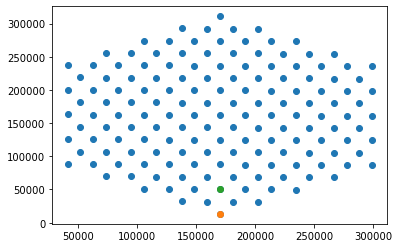

In [132]:
ztomm=0.0070313
[tax, tls]=rot_list_of_ax_ls(new_csv.ax_new_guess,new_csv.ls_guess,4.62302314783785)
plt.scatter(tax,tls)
plt.scatter(tax[0],tls[0])
plt.scatter(tax[8],tls[8])
print(np.min(tax)*ztomm,np.max(tax)*ztomm,np.min(tls)*ztomm,np.max(tls)*ztomm)

894.4403011251416


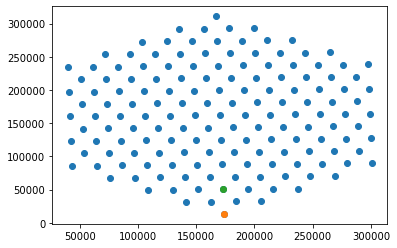

In [72]:
plt.scatter(tax,tls)
plt.scatter(tax[0],tls[0])
plt.scatter(tax[8],tls[8])
print(tax[0]-tax[8])

# how I figured out how to generate image files

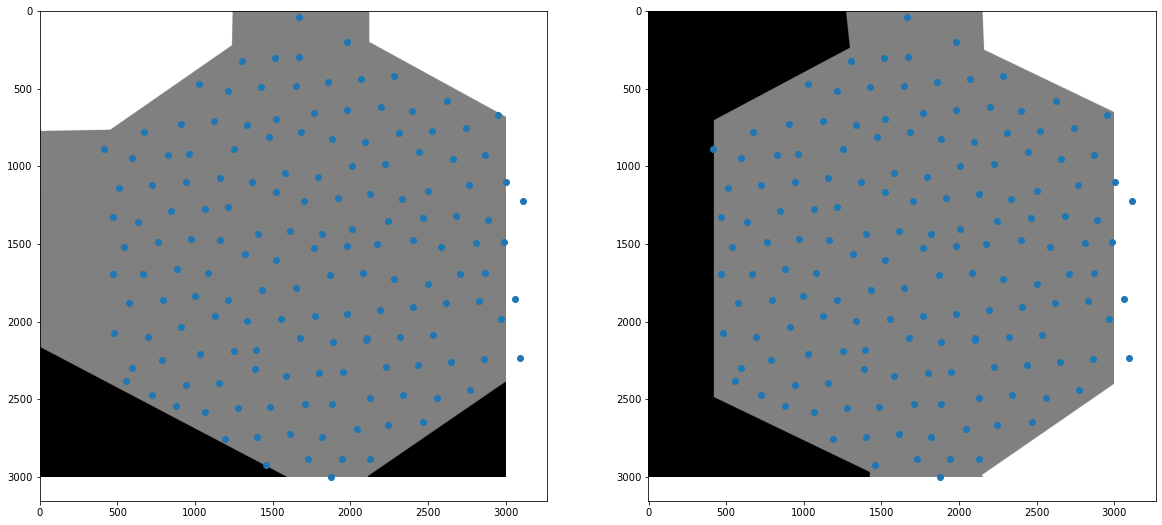

In [22]:
tif_ls = tif.imread('/Users/dennise/Downloads/drive-download-20240106T221701Z-001/rig_l_mult_20230919.tif')
tif_ax = tif.imread('/Users/dennise/Downloads/drive-download-20240106T221701Z-001/rig_ax3_mult_20230915.tif')
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))

ax1.imshow(tif_ls)
ax1.scatter(current_file.ax_new_guess/100,current_file.ls_guess/100)
ax2.imshow(tif_ax)
ax2.scatter(current_file.ax_new_guess/100,current_file.ls_guess/100)


In [86]:
# in bonsai, we take the zaber ls value, zaber ax3 value
# and index the image at img[int(ls/100),int(ax/100)]

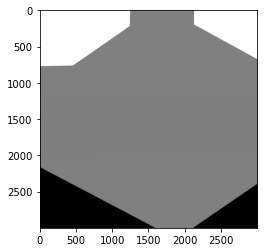

In [87]:
plt.imshow(tif_ls)

AttributeError: 'AxesSubplot' object has no attribute 'colorbar'

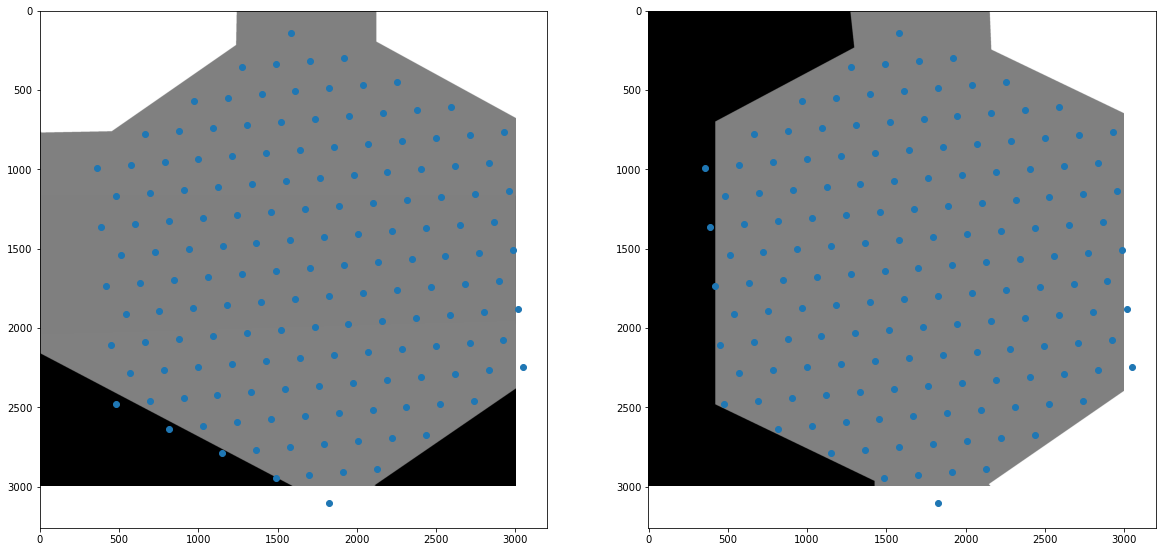

In [38]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))

ax1.imshow(tif_ls)
ax1.scatter(new_csv.ax_new_guess/100,new_csv.ls_guess/100)
ax2.imshow(tif_ax)
ax2.scatter(new_csv.ax_new_guess/100,new_csv.ls_guess/100)
ax2.scatter(new_csv.ax_new_guess[1]/100,new_csv.ls_guess[1]/100)

Text(0.5, 0, 'ax')

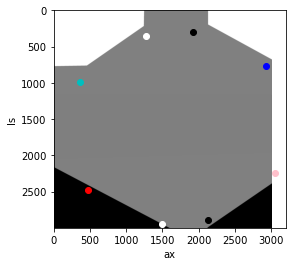

In [346]:
nm = "B4"
df = new_csv.copy()
plt.imshow(tif_ls)
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='k')
nm = "B1"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='w')

nm = "P1"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='w')
nm = "P4"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='k')

nm = "E1"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='c')
nm = "E13"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='b')

nm = "M1"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='r')
nm = "M13"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='pink')
plt.ylabel('ls')
plt.xlabel('ax')

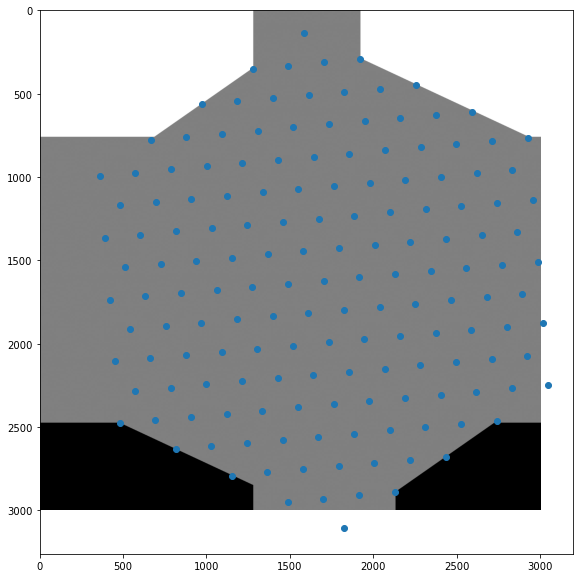

In [324]:
new_ls = np.zeros((3000,3000,3))

# fill vertical stripe from top to bottom
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"B1","B4")
new_ls[0:3000,ax_low:ax_high]=128
b_left = ax_low
b_right = ax_high

# fill horizontal stripe from ax 0 to 3000 and 
# ...highest ls btw E1,E13 and lowest ls between M1,M13
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"E1","E13")
start = ls_low
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"M1","M13")
end = ls_high
new_ls[start:end,0:3000]=128

# use above #s to fill in white on 'top', will be partially overwritten next
new_ls[0:start,0:b_left]=255
new_ls[0:start,b_right:3000]=255

# now add triangles to finish the hexagon
# fill between M1,P1 (bottom left triangle on image)
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"M1","P1")
[lss,axs] = getpoints((ls_high,ax_high),(ls_low,ax_low-1)) # returns integer locations on line
for i in np.arange(1,len(lss)):
    new_ls[end:lss[i],axs[i-1]:axs[i]]=128
    
# fill between P4/M13 (bottom right triangle on image)
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"P4","M13")
[lss,axs] = getpoints((ls_high,ax_low),(ls_low,ax_high+1)) # returns integer locations on line
for i in np.arange(1,len(lss)):
    if axs[i] < 3000:
        new_ls[ls_low:lss[i],axs[i-1]:axs[i]]=128

# there may be a gap on the bottom right inside the arena, fill it
new_ls[ls_low:3000,b_left:np.min(axs)]=128

# fill between E1/B1 (top left triangle on image)
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"E1","B1")
#E1 is high ls, low ax
[lss,axs] = getpoints((ls_high,ax_low),(ls_low,ax_high+1)) # returns integer locations on line
# fill from val to high_ls from ax-1 to ax
for i in np.arange(1,len(lss)):
    if axs[i]<3000:
        new_ls[lss[i]:ls_high,axs[i-1]:axs[i]]=128


# fill between B4/E13 (top right triangle on image), B4 is low/low
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"B4","E13")
[lss,axs] = getpoints((ls_low,ax_low),(ls_high,ax_high+1)) # returns integer locations on line
# fill from val to high_ls, ax-1 to ax
for i in np.arange(1,len(lss)):
    if axs[i]<3000:
        new_ls[lss[i]:ls_high,axs[i-1]:axs[i]]=128

plt.figure(figsize=(20,10))
plt.imshow(new_ls/255)
plt.scatter(new_csv.ax_new_guess/100, new_csv.ls_guess/100)

In [340]:
now = datetime.now()
ls_tif_filestring = "../../../rig_l_mult_"+now.strftime("%Y%m%d")+".tif"
tif.imsave(ls_tif_filestring,new_ls.astype('uint8'),photometric='rgb')

## now make AX

Text(0.5, 0, 'ax')

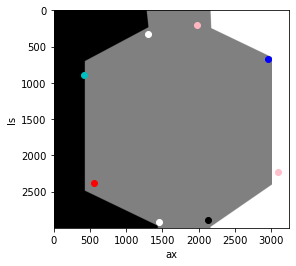

In [356]:
nm = "B4"
df = current_file.copy()
plt.imshow(tif_ax)
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='lightpink')
nm = "B1"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='w')

nm = "P1"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='w')
nm = "P4"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='k')

nm = "E1"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='c')
nm = "E13"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='b')

nm = "M1"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='r')
nm = "M13"
plt.scatter(df.ax_new_guess[df.name==nm]/100,df.ls_guess[df.name==nm]/100,c='pink')
plt.ylabel('ls')
plt.xlabel('ax')

2891 2249 3047 2129
765 2477 359 3047


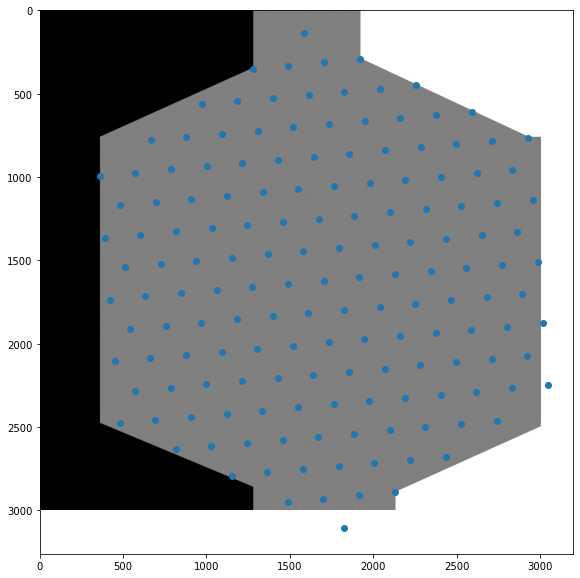

In [384]:
new_ax = np.zeros((3000,3000,3))

# first fill everything right of the middle with white
# B4 P4 get lowest ax value
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"B4","P4")
new_ax[:,ax_low:3000]=255

# next fill a vertical stripe
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"B1","B4")
new_ax[0:3000,ax_low:ax_high]=128
b_left = ax_low
b_right = ax_high

# next make a box from low_ls between E1/E13 and high ls between M1/M13 and low ax E1/M1 and high ax E13/M13
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"E1","E13")
a = ls_low
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"M1","M13")
b = ls_high
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"E1","M1")
c = ax_low
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"E13","M13")
d = ax_high
if d < 3000:
    new_ax[a:b,c:d]=128
else:
    new_ax[a:b,c:3000]=128
    
#now add triangles to finish the hexagon
# fill between M1,P1 (bottom left triangle on image)
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"M1","P1")
[lss,axs] = getpoints((ls_high,ax_high),(ls_low,c-1)) # returns integer locations on line
for i in np.arange(1,len(lss)):
    new_ax[b:lss[i],axs[i-1]:axs[i]]=128

# fill between P4/M13 (bottom right triangle on image)
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"P4","M13")
[lss,axs] = getpoints((ls_high,ax_low),(b,ax_high+1)) # returns integer locations on line
for i in np.arange(1,len(lss)):
    if axs[i] < 3000:
        new_ax[ls_low:lss[i],axs[i-1]:axs[i]]=128
print(ls_high,ls_low,ax_high,ax_low)
print(a,b,c,d)

# there may be a gap on the bottom right inside the arena, fill it
new_ax[ls_low:3000,b_left:np.min(axs)]=128

# fill between E1/B1 (top left triangle on image)
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"E1","B1")
#E1 is high ls, low ax
[lss,axs] = getpoints((a,ax_low),(ls_low,ax_high+1)) # returns integer locations on line
# fill from val to high_ls from ax-1 to ax
for i in np.arange(1,len(lss)):
    if axs[i]<3000:
        new_ax[lss[i]:ls_high,axs[i-1]:axs[i]]=128

# fill between B4/E13 (top right triangle on image), B4 is low/low
[ls_high,ls_low,ax_high,ax_low]=get_relative_vals(new_csv,"B4","E13")
[lss,axs] = getpoints((ls_low,ax_low),(ls_high,ax_high+1)) # returns integer locations on line
# fill from val to high_ls, ax-1 to ax
for i in np.arange(1,len(lss)):
    if axs[i]<3000:
        new_ax[lss[i]:ls_high,axs[i-1]:axs[i]]=128
        

plt.figure(figsize=(20,10))
plt.imshow(new_ax/255)
plt.scatter(new_csv.ax_new_guess/100, new_csv.ls_guess/100)

In [385]:
now = datetime.now()
ls_tif_filestring = "../../../rig_ax_mult_"+now.strftime("%Y%m%d")+".tif"
tif.imsave(ls_tif_filestring,new_ax.astype('uint8'),photometric='rgb')

17

ERROR! Session/line number was not unique in database. History logging moved to new session 181


# Procedure

## How I got the values for centers

In [2]:
# ask user for two points: E13 bottom point and M1 top point
# generate centers, plot
# format as spreadsheet with appropriate labels

In [3]:
# Emily playing around today:
# try to generate all points, find median for each tile?

In [51]:
L1 = [(219000,56600),(223000,64600),(231600,65200),(236600,58000),(233400,50100),(224200,49400)]
L1x = [val[0] for val in L1]
L1y = [val[1] for val in L1]
L1c = (np.median(L1x),np.median(L1y))

In [52]:
M1x = [238800]
M1y = [47200]
ls_row_offset = 252400-254400
ax_row_offset = 91400-70200
print(ls_row_offset,ax_row_offset)

-2000 21200


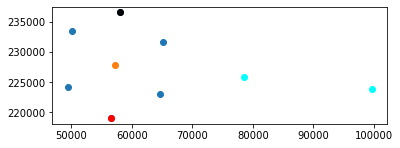

In [53]:
figure,axes= plt.subplots()
plt.scatter(L1y,L1x)
plt.scatter(L1c[1],L1c[0])
#axes.add_artist(patches.Circle((L1c[1],L1c[0]),radius=5500))
axes.set_aspect(1)
plt.scatter(L1y[0],L1x[0],c='r')
plt.scatter(L1y[3],L1x[3],c='k')
plt.scatter(L1c[1]+ax_row_offset,L1c[0]+ls_row_offset,color='cyan')

plt.scatter(L1c[1]+2*ax_row_offset,L1c[0]+2*ls_row_offset,color='cyan')
#plt.scatter(M_ax_cs[0:4],M_ls_cs[0:4],c='g')

In [54]:
print(np.median([L1y[0],L1y[3]]))
print(np.median([L1x[0],L1x[3]])+100)
L1c

57300.0
227900.0


(227900.0, 57300.0)

In [55]:
print(L1x[0],L1y[0])
print(L1x[3],L1y[3])

219000 56600
236600 58000


In [56]:
top_x_to_bottom_offset = L1x[3]-L1x[0]+200
top_y_to_bottom_offset = L1y[3]-L1y[0]

print(top_x_to_bottom_offset,top_y_to_bottom_offset)

17800 1400


In [57]:
x=219000+top_x_to_bottom_offset
y=56600+top_y_to_bottom_offset
print(x,y)
print(np.median([219000,x]))
print(np.median([56600,y]))

236800 58000
227900.0
57300.0


In [58]:
M1 = [M1x[0],M1y[0]]
print(M1)
M1c=[M1[0] + middle_from_0_offset[0],M1[1]+middle_from_0_offset[1]]
print(M1c)
print(middle_from_0_offset)

[238800, 47200]
[247700, 47900]
[8900, 700]


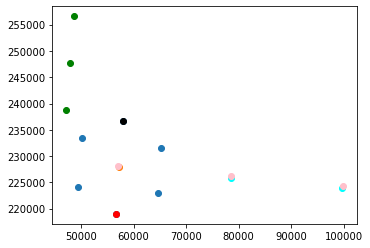

In [66]:
figure,axes= plt.subplots()
plt.scatter(L1y,L1x)
plt.scatter(L1c[1],L1c[0])
#axes.add_artist(patches.Circle((L1c[1],L1c[0]),radius=5500))
axes.set_aspect(1)
plt.scatter(L1y[0],L1x[0],c='r')
plt.scatter(L1y[3],L1x[3],c='k')
plt.scatter(L1c[1]+ax_row_offset,L1c[0]+ls_row_offset,color='cyan')

plt.scatter(L1c[1]+2*ax_row_offset,L1c[0]+2*ls_row_offset,color='cyan')
plt.scatter(L_ax_cs[0:3],L_ls_cs[0:3],c='pink')
plt.scatter(M1c[1],M1c[0],c='g')
plt.scatter(M1[1],M1[0],c='g')
plt.scatter(M1c[1]+middle_from_0_offset[1],M1c[0]+middle_from_0_offset[0],c='g')

31.23091028439965
31.14571285603311
0.5450663253978292
0.5436002488261539


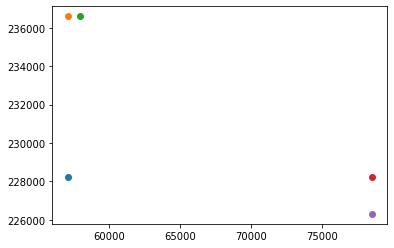

In [83]:
L1cax=L_ax_cs[0]
L1cls=L_ls_cs[0]
L2cax=L_ax_cs[1]
L2cls=L_ls_cs[1]
L1tax=L1y[3]
L1tls=L1x[3]

lineA=math.dist((L1cax,L1cls),(L1cax,L1tls))
lineH=math.dist((L1cax,L1cls),(L1tax,L1tls))
print(math.degrees(math.cos(lineA/lineH)))

lineA=math.dist((L1cax,L1cls),(L2cax,L1cls))
lineH=math.dist((L1cax,L1cls),(L2cax,L2cls))
print(math.degrees(math.cos(lineA/lineH)))

# should get the same angle if
# cosine(L1cax,L1cls:L1cax,L1tls line length / L1cax,L1cls:L1tax,L1tls)
# cosine(L1cax,L1cls:L2cax,L1cls/L1cax,L1cls:L2cax,L2cls)

plt.scatter(L1cax,L1cls)
plt.scatter(L1cax,L1tls)
plt.scatter(L1tax,L1tls)
plt.scatter(L2cax,L1cls)
plt.scatter(L2cax,L2cls)

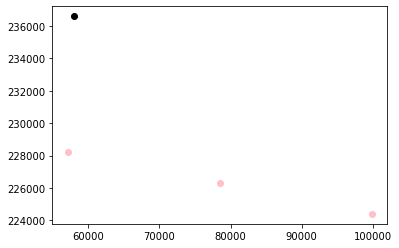

In [67]:
plt.scatter(L_ax_cs[0:3],L_ls_cs[0:3],c='pink')
plt.scatter(L1y[3],L1x[3],c='k')


In [47]:
zipped=zip(L_ls_cs,L_ax_cs)
[grp for grp in zipped]

[(228200, 57100),
 (226300, 78500),
 (224400, 99900),
 (222500, 121300),
 (220600, 142700),
 (218700, 164100),
 (216800, 185500),
 (214900, 206900),
 (213000, 228300),
 (211100, 249700),
 (209200, 271100),
 (207300, 292500)]

In [29]:
# make centers map first
# then generate points from there 
# points from center:

In [30]:
xval_offsets=L1x-L1c[0]

In [31]:
yval_offsets=L1y-L1c[1]

In [ ]:
r

In [42]:
L1c=(L_ls_cs[0],L_ax_cs[0])

[-62.57857 -34.45337  26.01581  61.17231  38.67215 -26.01581]
[ -4.92191  51.32849  55.54727   4.92191 -50.62536 -55.54727]


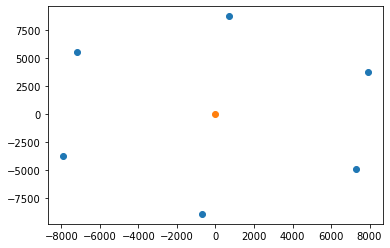

In [45]:
L1c=(0,0)
# confirm that our offsets + centers = corner points
plt.scatter(yval_offsets+L1c[1],xval_offsets+L1c[0])
plt.scatter(L1c[1],L1c[0])
#plt.scatter(L1y,L1x)
print((xval_offsets+L1c[0])*0.0070313)
print((yval_offsets+L1c[1])*0.0070313)

In [18]:
M1top=M1
print(M1top)
print(M1c)
M2top = [237000,68800]
print(M2top)
M2c_from_top = [M2top[0]+middle_from_0_offset[0],M2top[1]+middle_from_0_offset[1]]

[238800, 47200]
[247700, 47900]
[237000, 68800]


In [91]:
# now get offset between tiles in same row
row_ls_within= M2top[0]-M1top[0]
row_ax_within = M2top[1]-M1top[1]
row_ls_within,row_ax_within #M1 + row__within = M2

(-1800, 21600)

In [93]:
print(M1c[0]+row_ls_within,M1c[1]+row_ax_within)
print(M2c_from_top)

245900 69500
[245900, 69500]


In [25]:
# D row:
Dls = [84500,82200,80400,78600,76800,74800,72600,71100,69200] #from D2 to D10
Daxs = [88500,109900,131200,152600,174000,195400,216900,238000,259400] # from D2-D10
delta_ls = []
delta_ax = []
for i in np.arange(0,8):
    delta_ls.append(Dls[i+1] - Dls[i])
    delta_ax.append(Daxs[i+1] - Daxs[i])
print(delta_ls,delta_ax)

[-2300, -1800, -1800, -1800, -2000, -2200, -1500, -1900] [21400, 21300, 21400, 21400, 21400, 21500, 21100, 21400]


In [27]:
print(np.mean(delta_ls),np.mean(delta_ax))
print(np.median(delta_ls),np.median(delta_ax))

-1912.5 21362.5
-1850.0 21400.0


L1 to M2, 1
[17400, 17800, 17200, 17600, 17600, 17800, 17400, 17600, 17700]
[12100, 12300, 12100, 12200, 12200, 12200, 12100, 12300, 12200]
17566.666666666668 12188.888888888889
17600.0 12200.0
M1 to L1, 0
[-19400, -19800, -19600, -19400, -19500, -19500, -19400, -19500, -19500, -19500]
[9200, 9200, 6200, 12200, 9000, 9200, 9200, 9400, 9000, 9300]
-19510.0 9190.0
-19500.0 9200.0


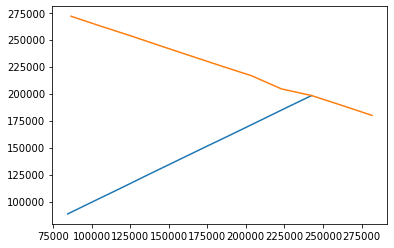

In [47]:
#L1_to_M2
ls_vals = [84500,101900,119700,136900,154500,172100,189900,207300,224900,242600]
ax_vals = [88500,100600,112900,125000,137200,149400,161600,173700,186000,198200]
plt.plot(ls_vals,ax_vals)
delta_ls=[]
delta_ax=[]
for i in np.arange(0,len(ls_vals)-1):
    delta_ls.append(ls_vals[i+1] - ls_vals[i])
    delta_ax.append(ax_vals[i+1] - ax_vals[i])
    
print('L1 to M2, 1')
print(delta_ls)
print(delta_ax)
print(np.mean(delta_ls),np.mean(delta_ax))
print(np.median(delta_ls),np.median(delta_ax))


ls_vals = [281800,262400,242600,223000,203600,184100,164600,145200,125700,106200,86700]
ax_vals = [179800,189000,198200,204400,216600,225600,234800,244000,253400,262400,271700]
plt.plot(ls_vals,ax_vals)
delta_ls=[]
delta_ax=[]
for i in np.arange(0,len(ls_vals)-1):
    delta_ls.append(ls_vals[i+1] - ls_vals[i])
    delta_ax.append(ax_vals[i+1] - ax_vals[i])

print('M1 to L1, 0')
print(delta_ls)
print(delta_ax)
print(np.mean(delta_ls),np.mean(delta_ax))
print(np.median(delta_ls),np.median(delta_ax))


In [103]:
#checking things work in both directions
M1_to_L1_offset = [219000-238800,56600-47200]
L1_to_M2_offset = [237000-219000,68800-56600]
print(M1_to_L1_offset,L1_to_M2_offset)
print(L1c[0]+L1_to_M2_offset[0],L1c[1]+L1_to_M2_offset[1])
print(M2c_from_top)
print(M1c[0]+M1_to_L1_offset[0],M1c[1]+M1_to_L1_offset[1])
print(L1c)

[-19800, 9400] [18000, 12200]
245900.0 69500.0
[245900, 69500]
227900 57300
(227900.0, 57300.0)
